In [1]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd

# Four explicit models

This section defines four toy autoencoders, each of the form
$y = \text{ReLU}(W^tWx + b)$, where $\text{ker}(W)$ has dimension 1. You can think of these as special neural network autoencoders with a bottleneck layer of one dimension less than the input and output layers.

<br>

The autoencoders are designed to reproduce vectors in $\mathbb{R}^n$, drawn from a special distribution. Each coordinate is independently chosen to be either uniform random in $[0, 1]$ (with probability $s$)  or simple $0$ (with probability $1-s$). The parameter $s$ is called the **sparsity**.

To measure loss between a target $x = (x_1, \ldots, x_n)$ and its reconstruction $y = (y_1, \ldots, y_n)$, we're using a weighted squared error:

loss = $(x_1 - y_1)^2 + (x_2 - y_2)^2 + \ldots + (x_{n-1} - y_{n-1})^2 + r(x_n - y_n)^2$

The factor of $r$ on the last term is called the **relative weight**.

<br>

To define the models, we consider two ways of mapping to a lower-dimensional space: either simply ignoring a coordinate, or combining ("superimposing") two coordinates. We also consider two possibilities for each: the last, specially weighted coordinate is mapped to a lower-dimensional space, or it is not.

<br>

Concretely, Let $P_2 = \begin{pmatrix} 1 & -1 \\ -1 & 1 \end{pmatrix}$. Geometrically, this is a projection orthogonal to $(1, 1)$ scaled by $\sqrt{2}$. Informally, we can think of this as modeling a simple kind of superposition among two coordinates.

Let $I_n$ be the identity matrix on $\mathbb{R}^n$.
<br><br>


Consider the following linear transformations from $\mathbb{R}^n \to \mathbb{R}^{n}$.

Let $D_{first} = (0) \oplus I_{n-1}$ be the orthogonal projection that just discards the first coordinate, setting it to zero.

Let $D_{last} = I_{n-1} \oplus (0)$ be the orthogonal projection that just discards the last coordinate, setting it to zero.

Let $S_{first} = P_2 \oplus I_{n-2}$, modeling a superposition among the first two coordinates.

Let $S_{last} = I_{n-2} \oplus P_2 $, modeling a superposition among the last two coordinates.

Each of these is a symmetric positive semi-definite rank $n-1$ matrix, and so each can be written as $W^tW$ for some $W: \mathbb{R}^n \to \mathbb{R}^{n-1}$.

<br>

For a given sparsity parameter $s$, we will consider four tiny "neural networks." The first two include small bias terms that reflect the expected value of the coordinate being discarded. (Here $e_1$ and $e_n$ are the first and last basis vectors.)

$f_s(x) = \text{ReLU}(D_{first}x  + \frac{\displaystyle s}{\displaystyle 2}e_1)$

$g_s(x) = \text{ReLU}(D_{last}x  + \frac{\displaystyle s}{\displaystyle 2}e_n)$

$h_{first}(x) = \text{ReLU}(S_{first}x) \left(= (\text{ReLU}(x_1 - x_2), \text{ReLU}(x_2 - x_1), x_3, \ldots, x_n)\right)$

$h_{last}(x) = \text{ReLU}(S_{last}x) \left(= (x_1, \ldots, x_{n-2}, \text{ReLU}(x_n - x_{n-1}), \text{ReLU}(x_{n-1} - x_n))\right)$

In particular, focusing on the *discarded* coordinate in the first two models,

$[f_s(x)]_1 = \text{ReLU}(0 + \frac{s}{2})$ = $\frac{s}{2}$

$[g_s(x)]_n = \text{ReLU}(0 + \frac{s}{2})$ = $\frac{s}{2}$

<!-- # Calculating Expected Loss



We can calculate the expected value of this loss explicitly for these tiny networks. For $f_s$ and $g_s$ we need only look at the discarded coordinate. With probability $1-s$ the loss will be the square of the bias term, and with probability $s$ can be worked out as simple integral:

$$
\mu_s := (1-s)\,\delta_0 + s\,\text{Unif}[0, 1]
$$

$$
\begin{aligned}
\text{loss}(f_s) &= E_{x\sim \mu_s}[f_s(x) - x] \\
&= (1-s)(f_s(0) - 0)^2 + s\int_{0}^{1} \left(f_s(x) - x \right)^2 \, dx \\
&= (1-s)\left(\frac{s}{2}\right)^2 + s\int_{0}^{1} \left(\frac{s}{2} - x\right)^2 \, dx \\
&= \frac{s}{3} - \frac{s^2}{4}
\end{aligned}
$$

$$\text{loss}(g_s) = r \, \text{loss}(f_s) = r(\frac{s}{\displaystyle 3} - \frac{s^2}{4})$$

The networks $h_{first}$ and $h_{last}$ reconstruct vectors perfectly unless both of their superimposed coordinates are non-zero; this happens with probability $s^2$. The matrix $P_2$ sends $(x, y)$ to $(x - y, y - x)$, which has reconstruction error $2 \min(x, y)^2$ when both coordinates have loss weighted with 1, and error $(1 + r)\min(x, y)^2$ when one coordinate has weight $r$. This implies

$$
\begin{aligned}
\text{loss}(h_{first}(x)) 
&= s^2 \int_{0}^{1} \int_{0}^{1} \left\{ (\text{ReLU}(x - y) - x)^2 + (\text{ReLU}(y - x) - y)^2 \right\} \, dy \, dx \\
&= s^2 \int_{x \geq y, x \in [0, 1], y \in [0, 1]} \left\{ (\text{ReLU}(x - y) - x)^2 + (\text{ReLU}(y - x) - y)^2 \right\} \, dy \, dx \\
&\quad+ s^2 \int_{x < y, x \in [0, 1], y \in [0, 1]} \left\{ (\text{ReLU}(x - y) - x)^2 + (\text{ReLU}(y - x) - y)^2 \right\} \, dy \, dx \\
&= s^2 \int_{x \geq y, x \in [0, 1], y \in [0, 1]} \left\{ (x - y - x)^2 + (0 - y)^2 \right\} \, dy \, dx + s^2 \int_{x < y, x \in [0, 1], y \in [0, 1]} \left\{ (0 - x)^2 + (y - x - y)^2 \right\} \, dy \, dx \\
&= s^2 \int_{x \geq y, x \in [0, 1], y \in [0, 1]} \left\{ (-y)^2 + (-y)^2 \right\} \, dy \, dx + s^2 \int_{x < y, x \in [0, 1], y \in [0, 1]} \left\{ (-x)^2 + (-x)^2 \right\} \, dy \, dx \\
&= s^2 \int_{x \geq y, x \in [0, 1], y \in [0, 1]} 2 y^2 \, dy \, dx + s^2 \int_{x < y, x \in [0, 1], y \in [0, 1]} 2 x^2 \, dy \, dx \
\end{aligned}
$$

By symmetry, the two integrals are equal. Then

$$
\begin{aligned}
\text{loss}(h_{first}(x)) 
&= 2 s^2 \int_{x \geq y, x \in [0, 1], y \in [0, 1]} 2 y^2 \, dy \, dx \\
&= 2 s^2 \int_{0}^{1} \int_{0}^{x} 2 y^2 \, dy \, dx \\
&= 2 s^2 \int_{0}^{1} \left[ \frac{2y^3}{3} \right]_{0}^{x} \, dx \\
&= 2 s^2 \int_{0}^{1} \frac{2x^3}{3} \, dx \\
&= 2 s^2 \left[ \frac{2x^4}{12} \right]_{0}^{1} \\
&= \frac{ s^2}{ 3}
\end{aligned}
$$

In the $r$-weighted case, one of the two squared-error terms carries factor $r$, so the total coefficient changes from $2$ to $(1+r)$:

$$\text{loss}(h_{last}(x)) = 2 s^2 \int_{0}^{1} \int_{0}^{x} (1 + r)y^2 \, dy \, dx = \frac{ (1 + r) s^2}{ 6}$$

 -->

 


# Calculating Expected Loss

We can compute the expected value of the loss explicitly for these toy networks. For $f_s$ and $g_s$, we only need to consider the **discarded coordinate**. With probability $1-s$, that coordinate is exactly $0$ and the loss equals the square of the bias term; with probability $s$, it is uniformly distributed over $[0,1]$, leading to a simple one-dimensional integral.

We can compute the expected loss explicitly for these toy networks. Let $X$ denote the discarded coordinate, and let its law be the mixture

$$
\mu_s := (1-s)\,\delta_0 \;+\; s\,\mathrm{Unif}[0,1].
$$

where $\delta_0$ is the point mass at $0$. With this notation, for $f_s$ and $g_s$, we only need to consider $X$: with probability $1-s$ it is exactly $0$, and with probability $s$ it is uniformly distributed on $[0,1]$, leading to a simple one-dimensional integral.

## Loss for $f_s$

$$
\begin{aligned}
\mathrm{loss}(f_s)
&= \mathbb{E}_{x\sim \mu_s}\!\big[(f_s(x)-x)^2\big] \\
&= (1-s)\,\big(f_s(0)-0\big)^2 \;+\; s \int_{0}^{1} \big(f_s(x)-x\big)^2 \, dx.
\end{aligned}
$$

For the discarded coordinate, $f_s$ outputs the bias $\tfrac{s}{2}$, so $(f_s(x)-x)^2 = (\tfrac{s}{2}-x)^2$. Hence
$$
\begin{aligned}
\mathrm{loss}(f_s)
&= (1-s)\left(\frac{s}{2}\right)^2 \;+\; s\int_{0}^{1} \left(\frac{s}{2}-x\right)^2 \, dx \\
&= \frac{s}{3} - \frac{s^2}{4}.
\end{aligned}
$$

## Loss for $g_s$

Since the last coordinate carries relative weight $r$, we obtain
$$
\mathrm{loss}(g_s) \;=\; r\,\mathrm{loss}(f_s) \;=\; r\!\left(\frac{s}{3}-\frac{s^2}{4}\right).
$$

## Loss for $h_{\text{first}}$ and $h_{\text{last}}$

The networks $h_{\text{first}}$ and $h_{\text{last}}$ reconstruct perfectly unless **both** of the superimposed coordinates are non-zero; this occurs with probability $s^2$. Since $P_2(x,y)=(x-y,\;y-x)$, we have

- with unit weights on both coordinates, the squared-error equals $2\,\min(x,y)^2$;
- if one coordinate is weighted by $r$, the squared-error equals $(1+r)\,\min(x,y)^2$.

Thus, for $h_{\text{first}}$ (both coordinates weighted by 1),
$$
\begin{aligned}
\mathrm{loss}\!\left(h_{\text{first}}\right)
&= s^2 \iint_{[0,1]^2} \Big\{ \big(\operatorname{ReLU}(x-y)-x\big)^2 + \big(\operatorname{ReLU}(y-x)-y\big)^2 \Big\}\,dy\,dx \\
&= s^2\!\left( \iint_{\{x\ge y\}} 2y^2\,dy\,dx \;+\; \iint_{\{x<y\}} 2x^2\,dy\,dx \right) \\
&\overset{\text{By symmetry}}{=} 2s^2 \iint_{\{x\ge y\}} 2y^2\,dy\,dx \\
&= 2s^2 \int_{0}^{1}\!\!\int_{0}^{x} 2y^2\,dy\,dx \\
&= \frac{s^2}{3}.
\end{aligned}
$$

In the $r$-weighted case, **one** of the two squared-error terms carries factor $r$, so the total coefficient changes from $2$ to $(1+r)$:
$$
\mathrm{loss}\!\left(h_{\text{last}}\right)
= 2 s^2 \int_{0}^{1}\!\!\int_{0}^{x} (1+r)\,y^2 \, dy \, dx
= \frac{(1+r)s^2}{6}.
$$


In [2]:
# Define explicit expressions for expected loss


def loss_f(r, s):
    return s / 3 - s * s / 4


def loss_g(r, s):
    return r * loss_f(r, s)


def loss_h_first(r, s):
    return s * s / 3


def loss_h_last(r, s):
    return (1 + r) * s * s / 6

# A "phase" diagram of optimal models

For each value of the sparsity $s$ and relative weight $r$, we can ask which of these models is best. The code below creates a plot that answers this question.



In [3]:
# Set start and end points for parameter sweep
log_weight_start = -1
log_weight_end = 1
log_sparsity_start = 0
log_sparsity_end = -2


def interpolate(a, b, n, steps):
    return a + (b - a) * n / (steps - 1)


# Plot the "phase diagram"
def add_log_ticks(steps):
    def make_log_ticks(a, b, n, steps):
        scale = np.arange(0, n) / (n - 1)
        labels = 10 ** (b * scale + a * (1 - scale))
        ticks = scale * (steps - 1)
        return (ticks, labels)

    (ticks, labels) = make_log_ticks(log_weight_start, log_weight_end, 3, steps)
    plt.xticks(ticks=ticks, labels=labels)
    plt.xlabel(" weight")
    (ticks, labels) = make_log_ticks(log_sparsity_start, log_sparsity_end, 4, steps)
    plt.yticks(ticks=ticks, labels=labels)
    plt.ylabel("sparsity")

In [4]:
def show_phase_matrix(matrix, cmap, title, function_labels, steps):
    K = len(function_labels)
    fig, ax = plt.subplots(figsize=(6, 6))

    boundaries = np.arange(-0.5, K + 0.5, 1.0)
    norm = mcolors.BoundaryNorm(boundaries, cmap.N, clip=True)

    ax.imshow(
        matrix,
        cmap=cmap,
        norm=norm,
        interpolation="nearest",
        aspect="equal",
    )

    add_log_ticks(steps)

    n_rows, n_cols = matrix.shape
    xticks = [0, n_cols // 2, n_cols - 1]
    yticks = [0, n_rows // 2, n_rows - 1]
    ax.xaxis.set_major_locator(FixedLocator(xticks))
    ax.xaxis.set_major_formatter(FixedFormatter(["0.1x", "1.0x", "10x"]))
    ax.yaxis.set_major_locator(FixedLocator(yticks))
    ax.yaxis.set_major_formatter(FixedFormatter(["0.01", "0.1", "1.0"]))

    ax.set_xlabel("Relative Feature Importance")
    ax.set_ylabel("Feature Density (1-S)")
    ax.set_title(title)

    handles = [
        mpatches.Patch(
            facecolor=cmap(norm(i)), edgecolor="black", label=function_labels[i]
        )
        for i in range(K)
    ]
    ax.legend(handles=handles, loc="lower right", frameon=True)

    fig.tight_layout()
    plt.show()

In [5]:
def show_sampling_matrix(color_matrix, title, steps):
    n_rows, n_cols, _ = color_matrix.shape
    fig, ax = plt.subplots(figsize=(6, 6))

    ax.imshow(color_matrix, vmin=0, vmax=1)
    add_log_ticks(steps)

    xticks = [0, n_cols // 2, n_cols - 1]
    yticks = [0, n_rows // 2, n_rows - 1]

    ax.xaxis.set_major_locator(FixedLocator(xticks))
    ax.xaxis.set_major_formatter(FixedFormatter(["0.1x", "1.0x", "10x"]))
    ax.yaxis.set_major_locator(FixedLocator(yticks))
    ax.yaxis.set_major_formatter(FixedFormatter(["0.01", "0.1", "1.0"]))

    ax.set_xlabel("Relative Feature Importance")
    ax.set_ylabel("Feature Density (1-S)")
    ax.set_title(title)
    fig.tight_layout()
    plt.show()

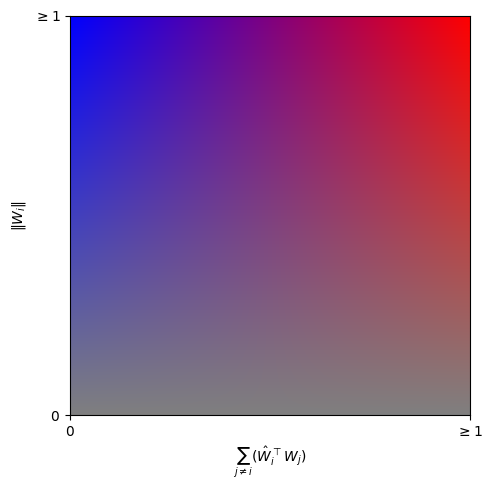

In [6]:
def xy_to_rgb(X, Y, gray_level=0.98):
    X = np.clip(X, 0.0, 1.0)
    Y = np.clip(Y, 0.0, 1.0)
    gray = np.array([gray_level, gray_level, gray_level], dtype=float)
    red_x = X
    green_x = np.zeros_like(X)
    blue_x = 1.0 - X
    R = (1.0 - Y) * gray[0] + Y * red_x
    G = (1.0 - Y) * gray[1] + Y * green_x
    B = (1.0 - Y) * gray[2] + Y * blue_x
    rgb = np.stack([R, G, B], axis=-1)
    return np.clip(rgb, 0.0, 1.0)


N = 512
x = np.linspace(0.0, 1.0, N)
y = np.linspace(0.0, 1.0, N)
X, Y = np.meshgrid(x, y, indexing="xy")
img = xy_to_rgb(X, Y, gray_level=0.5)

plt.figure(figsize=(6, 5))
plt.imshow(img, origin="lower", extent=[0, 1, 0, 1], aspect="equal")
plt.xlabel(r"$\sum_{j\neq i} (\hat{W}_i^\top W_j)$")
plt.ylabel(r"$\|W_i\|$")
plt.xticks([0, 1], [r"$0$", r"$\geq 1$"])
plt.yticks([0, 1], [r"$0$", r"$\geq 1$"])
plt.tight_layout()
plt.show()

## n_features = 2 and n_hidden = 1

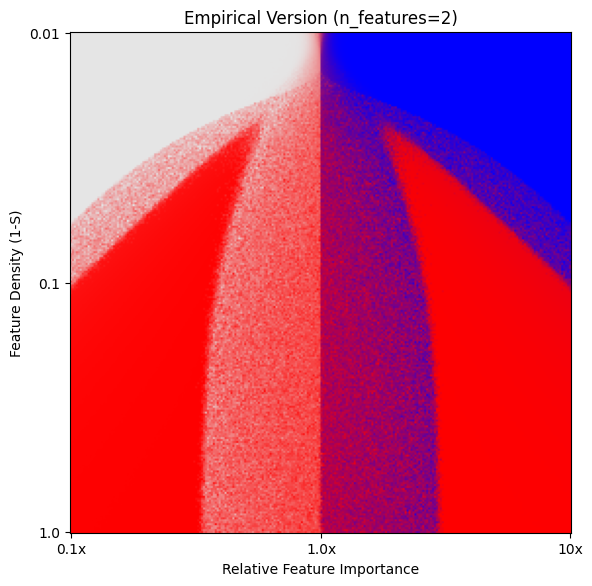

In [7]:
n_features = 2
steps = 256
input_path = f"output/{n_features}features-{steps}steps.csv"
df = pd.read_csv(input_path)
color_matrix = np.zeros((steps, steps, 3), dtype=float)
for _, row in df.iterrows():
    i = int(row["log_sparsity_index"])
    j = int(row["log_weight_index"])
    last_polysemanticity = row["last_polysemanticity"]
    last_norm = row["last_norm"]
    color_matrix[i, j] = xy_to_rgb(last_polysemanticity, last_norm, gray_level=0.9)
show_sampling_matrix(
    color_matrix, f"Empirical Version (n_features={n_features})", steps
)


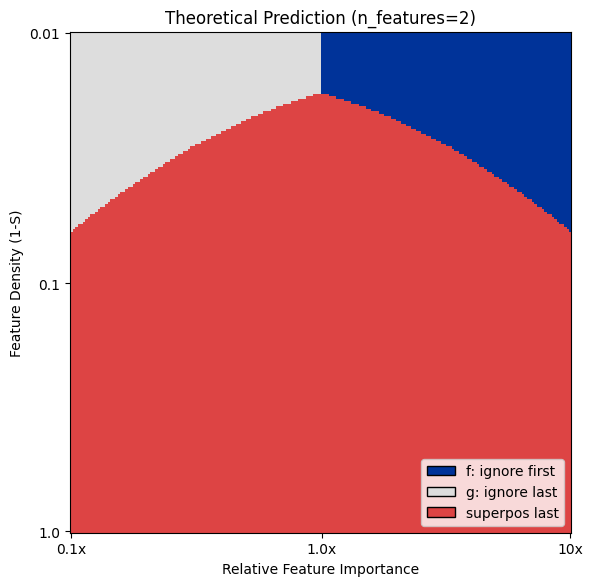

In [8]:
steps = 200
explicit_loss = np.zeros((steps, steps, 3))
log_sparsities = np.zeros((steps, steps))
log_weights = np.zeros((steps, steps))
for i in range(steps):
    log_sparsity = interpolate(log_sparsity_start, log_sparsity_end, i, steps)
    sparsity = 10**log_sparsity
    for j in range(steps):
        log_weight = interpolate(log_weight_start, log_weight_end, j, steps)
        rel_weight = 10**log_weight
        log_sparsities[i][j] = log_sparsity
        log_weights[i][j] = log_weight
        explicit_loss[i, j, 0] = loss_f(rel_weight, sparsity)
        explicit_loss[i, j, 1] = loss_g(rel_weight, sparsity)
        explicit_loss[i, j, 2] = loss_h_last(rel_weight, sparsity)

# Identify the model with least loss for each parameter configuration
model_with_least_explicit_loss = np.argmin(explicit_loss, axis=2)

# Create labels for the functions
function_labels = ["f: ignore first", "g: ignore last", "superpos last"]

function_colors = colors.ListedColormap(["#039", "#ddd", "#d44"])
show_phase_matrix(
    model_with_least_explicit_loss,
    function_colors,
    f"Theoretical Prediction (n_features={n_features})",
    function_labels,
    steps,
)

## n_features = 3 and n_hidden = 2

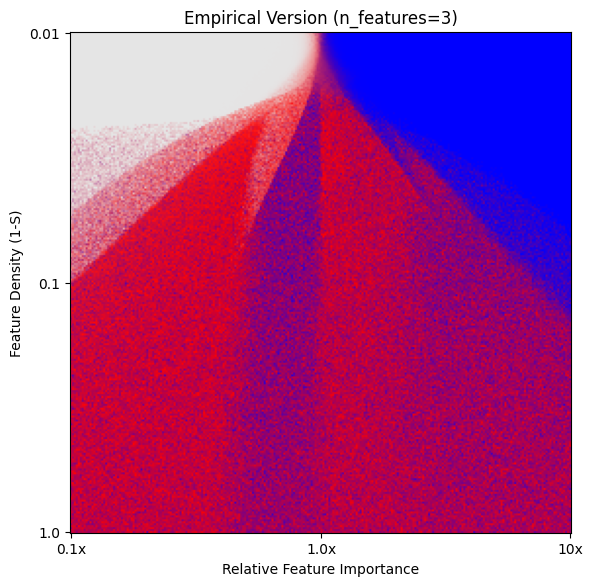

In [9]:
n_features = 3
steps = 256
input_path = f"output/{n_features}features-{steps}steps.csv"
df = pd.read_csv(input_path)
color_matrix = np.zeros((steps, steps, 3), dtype=float)
for _, row in df.iterrows():
    i = int(row["log_sparsity_index"])
    j = int(row["log_weight_index"])
    last_polysemanticity = row["last_polysemanticity"]
    last_norm = row["last_norm"]
    color_matrix[i, j] = xy_to_rgb(last_polysemanticity, last_norm, gray_level=0.9)
show_sampling_matrix(
    color_matrix, f"Empirical Version (n_features={n_features})", steps
)

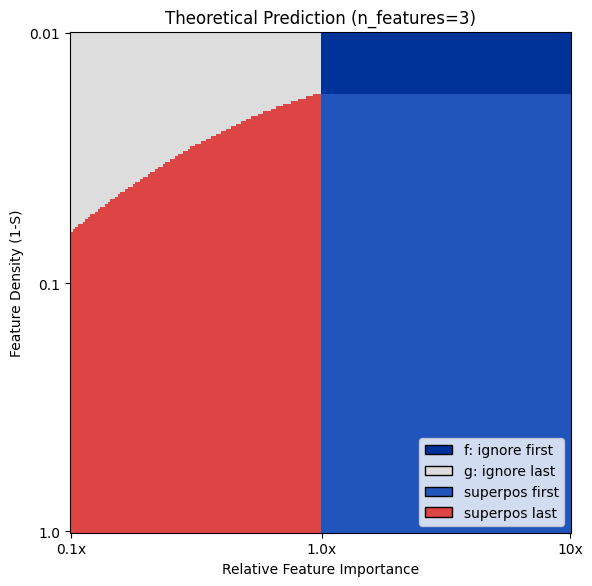

In [10]:
steps = 200
explicit_loss = np.zeros((steps, steps, 4))
log_sparsities = np.zeros((steps, steps))
log_weights = np.zeros((steps, steps))
for i in range(steps):
    log_sparsity = interpolate(log_sparsity_start, log_sparsity_end, i, steps)
    sparsity = 10**log_sparsity
    for j in range(steps):
        log_weight = interpolate(log_weight_start, log_weight_end, j, steps)
        rel_weight = 10**log_weight
        log_sparsities[i][j] = log_sparsity
        log_weights[i][j] = log_weight
        explicit_loss[i, j, 0] = loss_f(rel_weight, sparsity)
        explicit_loss[i, j, 1] = loss_g(rel_weight, sparsity)
        explicit_loss[i, j, 2] = loss_h_first(rel_weight, sparsity)
        explicit_loss[i, j, 3] = loss_h_last(rel_weight, sparsity)

# Identify the model with least loss for each parameter configuration
model_with_least_explicit_loss = np.argmin(explicit_loss, axis=2)

# Create labels for the functions
function_labels = [
    "f: ignore first",
    "g: ignore last",
    "superpos first",
    "superpos last",
]

function_colors = colors.ListedColormap(["#039", "#ddd", "#25b", "#d44"])
show_phase_matrix(
    model_with_least_explicit_loss,
    function_colors,
    f"Theoretical Prediction (n_features={n_features})",
    function_labels,
    steps,
)